In [25]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
from ultralytics.utils.plotting import save_one_box
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from PIL import Image
import tensorflow as tf
import keras
import Preprocess
import math
from roboflow import Roboflow
import json
import cv2
import os, glob, shutil

In [2]:
friends = {"Rolf","Bob","Anne"}
friends.add("Bob")
print(friends) # Kết quả là {"Bob","Jen","Anne","Rolf"}

{'Rolf', 'Anne', 'Bob'}


In [26]:
char_width = 35
char_height = 50

In [27]:
def find_contours(dimensions, img, check):
    # Find all contours in the image
    w = char_width + 10
    h = char_height + 10
    # w = char_width
    # h = char_height
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.imshow('ImageWindow',img)
    # cv2.waitKey()
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    if check == 1 : 
        cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:6]
    else :
        cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:5]
    ii = cv2.imread('contour.jpg')
    x_cntr_list = []
    img_res = []
    for cntr in cntrs:
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height:
            x_cntr_list.append(intX)  # stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((h,w))
            expand_x = 5
            expand_y = 3
            char = img[intY - expand_y:intY + intHeight + expand_y, intX - expand_x:intX + intWidth + expand_x]
            char = cv2.resize(char, (w, h),interpolation=cv2.INTER_LINEAR)
            # char = cv2.resize(char, (w, h),interpolation=cv2.INTER_CUBIC)
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            char = cv2.subtract(255, char)
            char_copy[0:h, 0:w] = char
            img_res.append(char_copy)  # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])  # stores character images according to their index
    img_res = np.array(img_res_copy)
    return img_res

In [28]:
def white_border(dilated_image):
    white = (255,255,255)
    thickness = 1
    dilated_image = cv2.line(dilated_image, (0, 0), (dilated_image.shape[1],0), color=white, thickness= thickness)
    dilated_image = cv2.line(dilated_image, (dilated_image.shape[1],0), (dilated_image.shape[1],dilated_image.shape[0]), color=white, thickness= thickness)
    dilated_image = cv2.line(dilated_image,  (dilated_image.shape[1],dilated_image.shape[0]), (0,dilated_image.shape[0]), color=white, thickness= thickness)
    dilated_image = cv2.line(dilated_image,  (0,dilated_image.shape[0]), (0, 0), color=white, thickness= thickness)
    return dilated_image

In [29]:
def segment_characters(image, check) :
    # Preprocess cropped license plate image
    img = cv2.resize(image, (333,75), interpolation= cv2.INTER_LINEAR)
    kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    thre_mor = cv2.morphologyEx(img, cv2.MORPH_DILATE, kerel3)
    _, img_binary = cv2.threshold(thre_mor, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary = white_border(img_binary)
    LP_WIDTH = img_binary.shape[0] 
    LP_HEIGHT = img_binary.shape[1] 
    # print(LP_HEIGHT, LP_WIDTH) 
    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/33,LP_WIDTH,LP_HEIGHT/7, LP_HEIGHT]
    # dimensions = [LP_WIDTH/333,3*LP_HEIGHT/2, LP_WIDTH/6, LP_HEIGHT/75]
    cv2.imwrite('contour.jpg',img_binary)
    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary , check)
    return char_list

In [30]:
def get_closer_plate(plate):
    imgGrayscaleplate, imgThreshplate = Preprocess.preprocess(plate)
    _, imgGrayscaleplate = cv2.threshold(imgGrayscaleplate, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # cv2.imshow("dilated_image",imgGrayscaleplate)
    # cv2.waitKey()
    # canny_image = cv2.Canny(imgThreshplate, 250, 255)  # Canny Edge
    dilated_image = cv2.dilate(imgGrayscaleplate, (3,3))

    img1 = dilated_image
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
    screenCnt = []
    for c in contours:
        peri = cv2.arcLength(c, True)  # Tính chu vi
        approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # làm xấp xỉ đa giác, chỉ giữ contour có 4 cạnh
        [x, y, w, h] = cv2.boundingRect(approx.copy())
        if (len(approx) == 4):
            screenCnt.append(approx)

            cv2.putText(plate, str(len(approx.copy())), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 3)

        for screenCnt in screenCnt:
            cv2.drawContours(plate, [screenCnt], -1, (0, 255, 0), 3)  # Khoanh vùng biển số xe

            ############## Find the angle of the license plate #####################
            (x1, y1) = screenCnt[0, 0]
            (x2, y2) = screenCnt[1, 0]
            (x3, y3) = screenCnt[2, 0]
            (x4, y4) = screenCnt[3, 0]
            array = [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
            array.sort(reverse=True, key=lambda x: x[1])
            (x1, y1) = array[0]
            (x2, y2) = array[1]
            doi = abs(y1 - y2)
            ke = abs(x1 - x2)
            angle = math.atan(doi / ke) * (180.0 / math.pi)

            ####################################

            ########## Crop out the license plate and align it to the right angle ################

            mask = np.zeros(imgGrayscaleplate.shape, np.uint8)
            new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1, )
            # cv2.imshow("new_image",new_image)
            # cv2.waitKey()
            # Cropping
            (x, y) = np.where(mask == 255)
            (topx, topy) = (np.min(x), np.min(y))
            (bottomx, bottomy) = (np.max(x), np.max(y))

            roi = plate[topx:bottomx, topy:bottomy]
            imgThresh = imgThreshplate[topx:bottomx, topy:bottomy]
            ptPlateCenter = (bottomx - topx) / 2, (bottomy - topy) / 2

            if x1 < x2:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, -angle, 1.0)
            else:
                rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, angle, 1.0)

            roi = cv2.warpAffine(roi, rotationMatrix, (bottomy - topy, bottomx - topx))
            imgThresh = cv2.warpAffine(imgThresh, rotationMatrix, (bottomy - topy, bottomx - topx))
            # plt.imshow(imgThresh, cmap='gray')
            img1 = imgThresh
            # cv2.imshow("new_image",img1)
            # cv2.waitKey()
    return img1


In [47]:
def image_detect(model, path):
    results = model.predict(path,confidence=40,overlap=30)
    results_json = results.json()
    if results_json['predictions'] == []:
        print(f"No predictions for {path} at confidence: {40} and overlap {40}")
    else:
        original_file = os.path.basename(path).split('/')[-1]
        results.save(os.curdir + f"/inference_images/inferred/{original_file}")
    # Show the results
        im = cv2.imread(path)
        for r in results:
            check = r['class']
            if check == "LP":
                x0 = r['x'] - r['width'] / 2#start_column
                x1 = r['x'] + r['width'] / 2#end_column
                y0 = r['y'] - r['height'] / 2#start row
                y1 = r['y'] + r['height'] / 2#end_row
                plate = im[int(y0):int(y1), int(x0):int(x1)]
                # cv2.imshow('haha',plate)
                plate = get_closer_plate(plate)
                # plate = rotate_and_crop(plate)
                cropped_top = plate[0:int(plate.shape[0]/2) + 3, 0 : plate.shape[1]]
                cropped_under = plate[int(plate.shape[0]/2) - 3 : plate.shape[0]]
                char1 = segment_characters(cropped_top, 0)
                char2 = segment_characters(cropped_under, 1)
                char = np.concatenate((char1,char2))
                # plt.imshow(char[1], cmap='gray')
                return char

In [32]:
def detect_moto_cropped_save(dir_path):
    for filename in os.listdir(dir_path):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(dir_path, filename)
            image_detect(image_path)

In [33]:
def process_license_plate(license_plate):
    line1 = ''.join(license_plate[:4])  
    line2 = ''.join(license_plate[4:]) 

    if license_plate[2].isalpha():
        # Chèn ký tự "-" giữa ký tự thứ 2 và thứ 3 của dòng trên
        line1 = line1[:2] + '-' + line1[2:]
    # Xu ly ky tu loi
    # if license_plate[3].isdigit():  

    line2 = line2.replace('Z', '2')
    line2 = line2.replace('B', '8')
    # line2 = line2.replace('B', '8')
    print(line1)
    print(line2)
    license_plate = line1 + line2
# List mẫu
my_list = ['9', '7', 'L', '1', '9', '6', 'Z', 'B', '7']

# Xử lý biển số
process_license_plate(my_list)

97-L1
96287


In [34]:
def recognition_by_path(model, chartest):
    label_str ="0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z"
    img_label = np.array(label_str.split())
    # print(len(img_label),'\n',img_label)
    list = []
    for i in range(len(chartest)):
        image_resize = cv2.resize(chartest[i], (char_width, char_height)) #w, h
        # image_resize = chartest[i]
        cv2.imwrite(f"image_cropped\Char\img{i}.jpg",image_resize)
        prep = model.predict(image_resize.reshape(1,char_height,char_width,1))
        predicted_class = np.argmax(prep)
        predicted_label = img_label[predicted_class]
        list.append(predicted_label)
    print(list)
    process_license_plate(list)

In [35]:
def show_char(chartest):
    fig, axs = plt.subplots(nrows=1, ncols=len(chartest), figsize=(35,50))
    for i in range(len(chartest)):
        ax = axs[i]
        ax.imshow(chartest[i], cmap='gray')  
    plt.show() 

In [36]:
# from crop_img import cropBoxes
ReadChar_model = keras.models.load_model("Model/LP_Modelv13.h5")
with open(r"roboflow_config.json") as f:
    config = json.load(f)
    ROBOFLOW_API_KEY = config["ROBOFLOW_API_KEY"]
    ROBOFLOW_WORKSPACE_ID = config["ROBOFLOW_WORKSPACE_ID"]
    print(ROBOFLOW_WORKSPACE_ID)
    ROBOFLOW_PROJECT_ID = config["ROBOFLOW_PROJECT_ID"]
    ROBOFLOW_VERSION_NUMBER = config["ROBOFLOW_VERSION_NUMBER"]
    ROBOFLOW_SIZE = config["ROBOFLOW_SIZE"]
    f.close()

## obtaining your API key: https://docs.roboflow.com/rest-api#obtaining-your-api-key
## create Roboflow object: https://docs.roboflow.com/python
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
workspace = rf.workspace(ROBOFLOW_WORKSPACE_ID)

project = workspace.project(ROBOFLOW_PROJECT_ID)
version = project.version(ROBOFLOW_VERSION_NUMBER)
model = version.model

# ## creating a directory to add images we wish to infer
# if os.path.exists(os.curdir + '/inference_images') is False:
#     os.mkdir(os.curdir + '/inference_images')

# ## creating directory to place Roboflow prediction images
# if os.path.exists(os.curdir + '/inference_images/inferred') is False:
#     os.mkdir(os.curdir + '/inference_images/inferred')

# ## creating directory to place prediction images with filled bounding boxes
# if os.path.exists(os.curdir + '/inference_images/cropBoxes') is False:
#     os.mkdir(os.curdir + '/inference_images/cropBoxes')

# for raw_data_ext in ['.jpg', '.jpeg', 'png']:
#     globbed_files = glob.glob(os.curdir + '/*' + raw_data_ext)
#     for img_file in globbed_files:
#         shutil.move(img_file, os.curdir + '/inference_images')

cdio-zmfmj
loading Roboflow workspace...
loading Roboflow project...


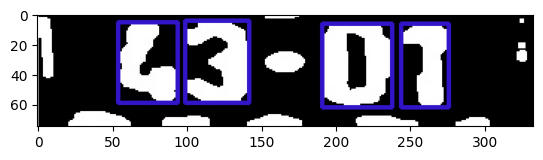

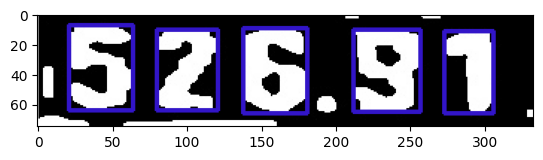

9


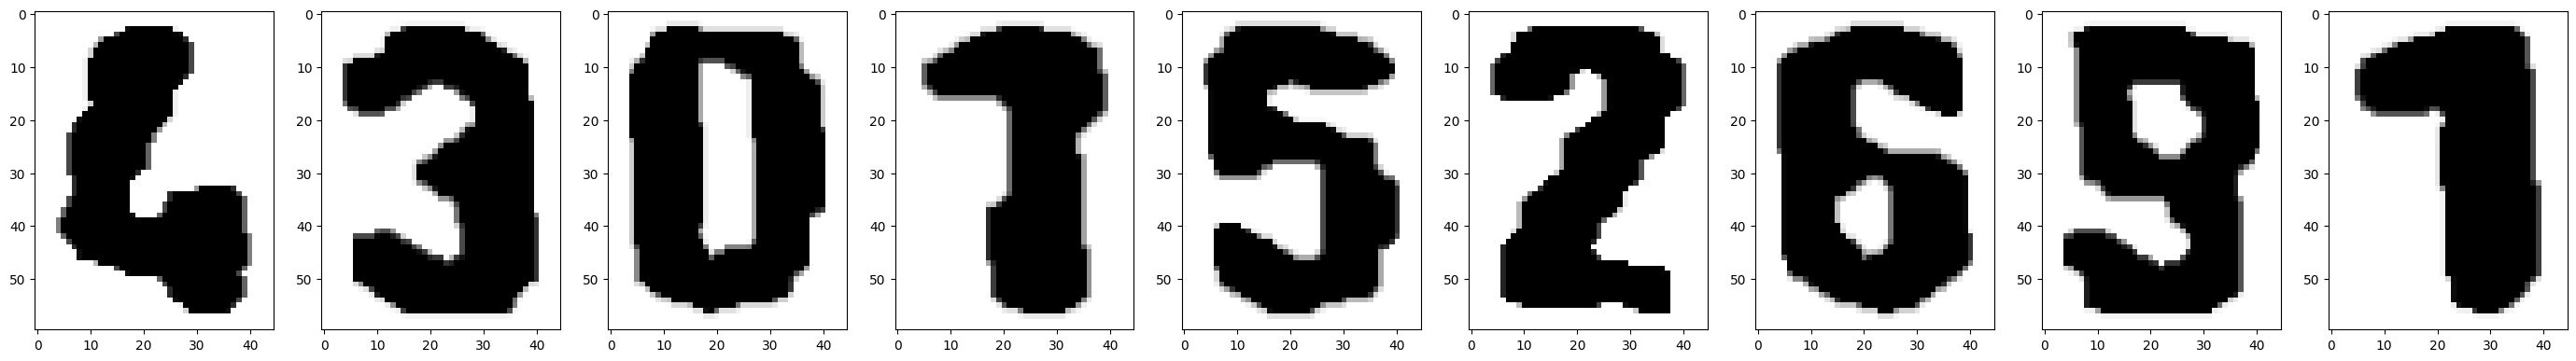

1/1 [==============================] - 0s 25ms/step
['4', '3', '0', 'T', '5', '2', '6', '9', '7']
430T
52697


In [49]:
image_path = r"393084360_1271784716831951_3977083545368319946_n.jpg"
# chartest = image_detect(DetectLP_model, image_path)
chartest = image_detect(model,image_path)

print(len(chartest))
if(len(chartest) > 0):
    show_char(chartest)
    recognition_by_path(ReadChar_model, chartest)

In [38]:
# import Recognition
# dir_path = r"image_cropped\Char"
# Recognition.recognition_by_folder(ReadChar_model, dir_path, 35, 64)